# Samples analysis
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hsimonfroy/benchmark-field-level/blob/main/examples/sample_analysis.ipynb)

Analyse cosmological model posterior samples.

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.2' # NOTE: jax preallocates GPU (default 75%)
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)
print(jdevices())

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload, Path
from getdist import plots

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname

save_dir = Path("save_dir")
save_path = save_dir / "example3"
save_dir.mkdir(parents=True, exist_ok=True)

[cuda(id=0)]
feynmangpu04.cluster.local


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Example 1: assess MCMC convergence

In [2]:
from montecosmo.chains import Chains
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh, theme, SetDark2
theme(usetex=True, font_size=12)

# Load chain files, which are just dictionaries of arrays, saved with jnp.savez
model = FieldLevelModel.load(save_dir / "model.yaml")

truth = dict(jnp.load(save_dir / 'truth.npz'))
mesh_true = jnp.fft.irfftn(truth['init_mesh'])
pow_true = model.spectrum(mesh_true)
delta_obs = model.masked2mesh(truth['obs']-1)
kptc_obs = model.powtranscoh(mesh_true, delta_obs)

obs = ['obs','Omega_m','sigma8','b1','b2','bs2','bn2','init_mesh']
obs = {k: truth[k] for k in obs}
model.condition(obs, frombase=True)

transforms = [
              partial(Chains.thin, thinning=1),                     # thin the chains
              model.reparam_chains,                                 # reparametrize sample variables into base variables
              partial(model.powtranscoh_chains, mesh0=mesh_true),       # compute mesh statistics
              partial(Chains.choice, n=10, names=['init','init_']), # subsample mesh 
              ]
chains = model.load_runs(save_path, 1, 3, transforms=transforms, batch_ndim=2)
names = ['cosmo','bias','init']
chains.shape

2025-05-09 00:22:40.597767: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Loading: example3, from run 1 to run 3 (included)
File save_dir/example3_3.npz does not exist, stopping at run 2


{'Omega_m': (8, 256),
 'alpha_ap': (8, 256),
 'alpha_iso': (8, 256),
 'init_mesh': (8, 256, 10),
 'kptc': ((8, 256, 7), (8, 256, 7), (8, 256, 7), (8, 256, 7)),
 'logdensity': (8, 256),
 'mse_per_dim': (8, 256),
 'n_evals': (8, 256),
 'sigma8': (8, 256)}

### Inspecting chains
We look for mixed chains (no visible trends), `n_eff`>500, `r_hat`<1.01

In [3]:
# names = ['bias','init']
chains.groups['bias'].remove('b1')
chains.groups['bias'].remove('b2')
chains.groups['bias'].remove('bs2')
chains.groups['bias'].remove('bn2')


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
 init_mesh[0]      0.10      0.44      0.08     -0.58      0.85    159.23      1.02
 init_mesh[1]      0.10      0.09      0.10     -0.03      0.25   1025.74      1.02
 init_mesh[2]      0.41      0.15      0.41      0.19      0.67    253.47      1.02
 init_mesh[3]     -0.23      0.12     -0.22     -0.41     -0.01    834.37      1.00
 init_mesh[4]      0.74      0.17      0.73      0.49      1.02    192.96      1.03
 init_mesh[5]      0.20      0.16      0.20     -0.05      0.46    370.61      1.02
 init_mesh[6]      0.06      0.50      0.06     -0.73      0.88    160.50      1.03
 init_mesh[7]      0.67      0.07      0.67      0.55      0.78   1194.13      1.02
 init_mesh[8]      0.01      0.48      0.01     -0.68      0.88    170.70      1.01
 init_mesh[9]     -0.65      0.13     -0.64     -0.86     -0.44    792.05      1.00
    alpha_iso      1.00      0.00      1.00      1.00      1.00     42.53  

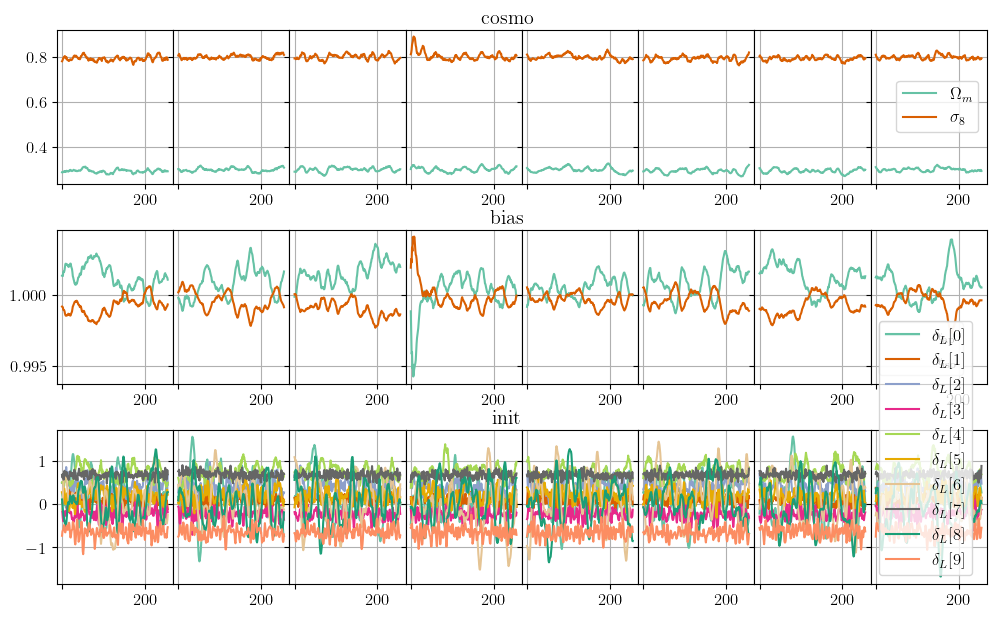

In [4]:
plt.figure(figsize=(12,6))
chains[['*~kptc']].flatten().plot(names)
chains[['*~kptc']].print_summary()

Removed no burn in


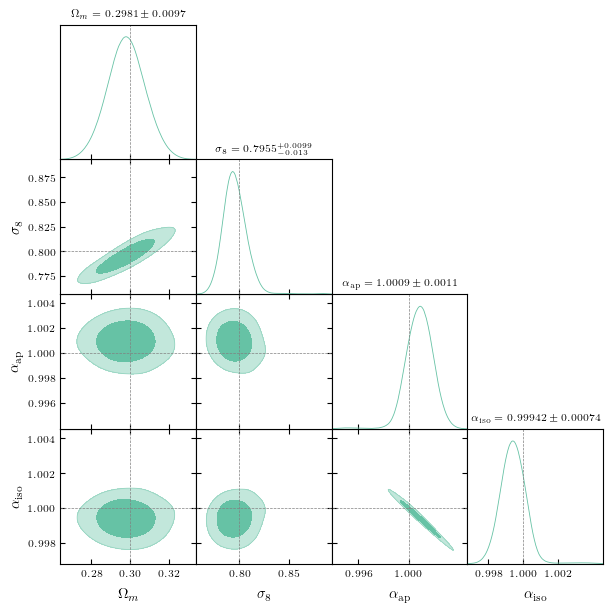

In [5]:
gdsamp = chains[names[:-1]].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

### Inspection at the field-Level
Power spectrum should converge close to the truth, and coherence must be on the order of the coherence between truth and obs

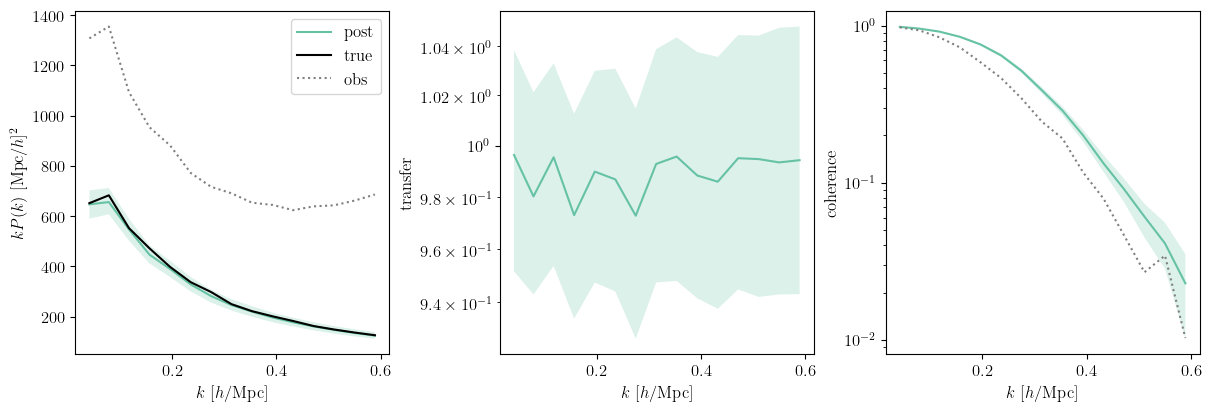

In [ ]:
prob = 0.95
log = False

plt.figure(figsize=(12, 4), layout="constrained")
kptc = tree.map(jnp.concatenate, chains['kptc'])
plot_powtranscoh(*tree.map(lambda x: jnp.median(x, 0), kptc), log=log, label='post')
plot_powtranscoh(*kptc, log=log, fill=prob)

plt.subplot(131)
plot_pow(*pow_true, 'k', log=log, label='true')
plot_pow(*kptc_obs[:2], ':', c='grey', log=log, label='obs')
plt.legend()

plt.subplot(133)
plot_coh(kptc_obs[0], kptc_obs[-1], ':', log=log, c='grey', label='obs')

## Example 2: quantify MCMC performance

### Number of eval per effective sample should converge. If so, that's a relevant metric.

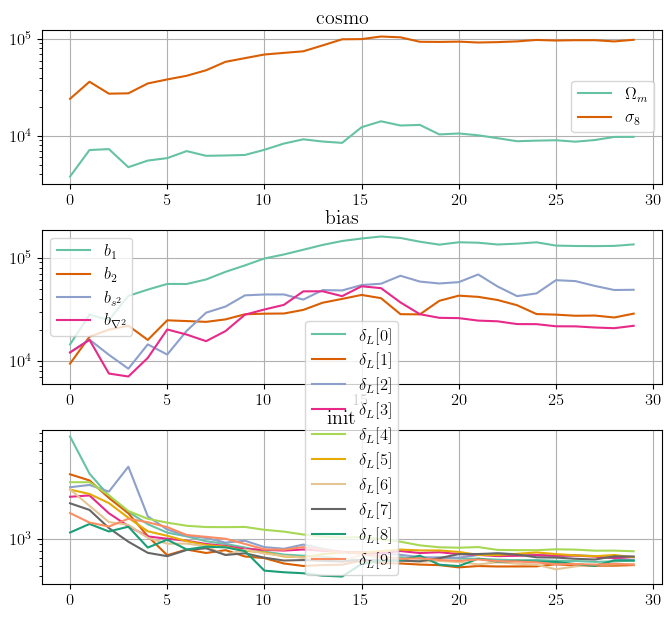

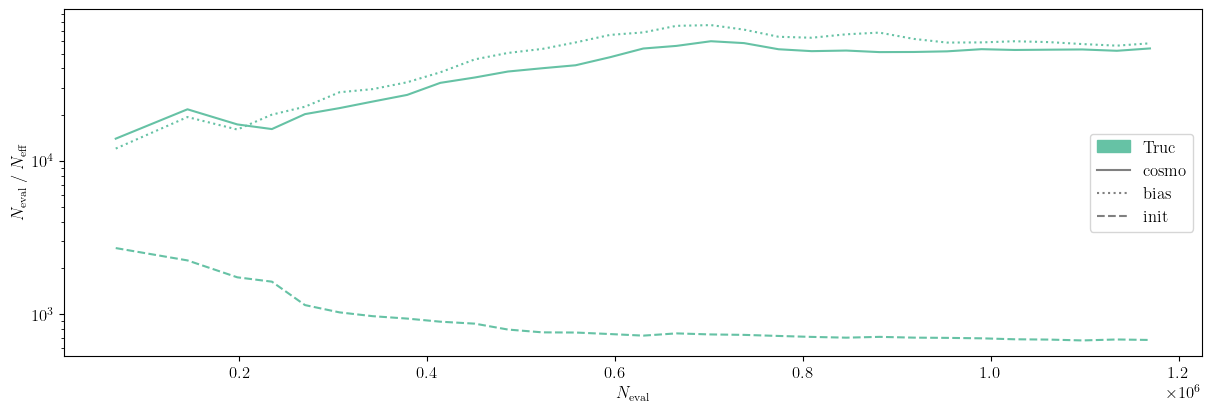

In [ ]:
plt.figure(figsize=(8, 6))
chains[['*~kptc']].flatten().cumtrans(Chains.eval_per_ess, 30).plot(names, 1, log=True)

labels = ['Truc']
metrics = []
cumess = chains[['*~kptc']].stackby(names).cumtrans(Chains.eval_per_ess, 30)
metrics.append(cumess)

def plot_fn(metrics, labels):
    plt.figure(figsize=(12, 4), layout="constrained")
    i_start = 0
    styles = ['-', ':', '--']
    for i_m, (metric, meth) in enumerate(zip(metrics, labels)):
        for i_g, (st, g) in enumerate(zip(styles, names)):
            plt.semilogy(metric['n_evals'][i_start:], metric[g][i_start:], st, c=SetDark2(i_m), label=g)

    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    handles = []
    for i_m, method in enumerate(labels):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_g, g in enumerate(names):
        handles.append(Line2D([], [], color='grey', linestyle=styles[i_g], label=g))

    plt.legend(handles=handles);

plot_fn(metrics, labels)
plt.xlabel("$N_{\\mathrm{eval}}$")
plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$");